<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Remote%20Sensing/mosis_download_precessing_modistsp_r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MODIS Images download and Processing with MODIStsp packages in R

Zia Ahmed, University at Buffalo


**NOTE: I failed to install MODIStsp() in my Google Drive**.  It is better to this package in native R!


MODIStsp is an R package that allows you to automate download and creation of raster time series MODIS Land Product. You can perform a few preprocessing steps on the MODIS product on a specific period and area (i.e., download, mosaics, reproject, resize, etc.). You can set all processing parameters in the easy-to-use GUI. For example, you can specify which layer(s) of the original HDF files you want to process and which QI(s) you want to extract from the aggregation of MODIS QA layers. The tool also allows you to compute time series (or Spectral indices) on the fly (standard or custom-defined by you via the GUI). The output is saved as a single-band Raster corresponding to the available acquisition date & output layer. You can also create virtual files that allow viewing the whole time series as one file using standard image processing / GIS software or an R script. Using a pre-defined Options File, you can also execute the program non-interactively within an R environment. The last thing you can do is schedule execution for MODIStps to automatically update the time series when you get a new image The R-package is an extremely useful tool for Remote Sensing community as it enables all major preprocessing steps needed to generate MODIS time series within a unified framework and does not require any special programming skills from its users.

Source: L. Busetto, and L. Ranghetti, [MODIStsp: An R package for automatic preprocessing of MODIS Land Products time series, Computers & Geosciences](https://www.sciencedirect.com/science/article/pii/S0098300416303107?via%3Dihub).

Typical preprocessing steps include:

-   downloading products as single-date HDF files from the HTTP or FTP distribution archives for specific dates and tiles;

-   mosaicing, resizing, and eventually reprojecting the raster images;

-   extracting the specific layers of interest for the analysis;

-   computing additional layers from the original ones (i.e. extract specific QIs from QA layers or compute Spectral Indexes (SI) from surface reflectance);

-   storing and organizing data to allow easy access to the time series of a given variable/parameter, eventually converting it into an easier-to-use format.

Install rpy2

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.4.2
Uninstalling rpy2-3.4.2:
  Successfully uninstalled rpy2-3.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp310-cp310-linux_x86_64.whl size=314928 sha256=6a6377a2e05fbcca44dfc8c9044fd71e89a97d20e21e70ef40be921a4118f9cb
  Stored in directory: /root/.cache/pip/wheels/73/a6/ff/4e75dd1ce1cfa2b9a670cbccf6a1e41c553199e9b25f05d953
Successfully built rpy2


### Mount Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%R
pkg <- c('tidyverse', 'raster', 'rgdal','terra','tidyterra', 'maptools', 'sf', 'classInt', 'RColorBrewer', 'remotes')
new.packages <- pkg[!(pkg %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

UsageError: Cell magic `%%R` not found.


In [6]:
%%R
pkg.d <- c('leaflet', 'shiny','shinydashboard','shinyFiles','shinyalert', 'rappdirs','shinyjs', 'leafem', 'mapedit', 'magrittr')
new.packages.d <- pkg.d[!(pkg.d %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages.d)) install.packages(new.packages.d, lib='drive/My Drive/R/')

In [ ]:
%%R
install.packages(c('scale', 'colorspace', 'cowplot'), lib='/content/drive/MyDrive/R')

In [ ]:
%%R
#library(devtools)
# install.packages("MODIStsp", lib='/content/drive/MyDrive/R')

In [40]:
%%R
.libPaths('/drive/MyDrive/R')
library (terra)
library (tidyterra)
library(sf)
library(raster)
library(rgdal)
library(luna)
library(geodata)
library(tidyverse)
library(raster)
#library(MODIStsp)
library(scales)
library(colorspace)

### How to use MODIStsp

The simplest way to use {Modistsp} is by using its powerful graphical user interface (GUI) to select the processing options and then execute the processing. Open the package and run the **MODIStsp()** function without arguments to use the GUI.

This opens a Shiny GUI from which processing options can be specified (and eventually saved or loaded). After specifying all required parameters, clicking on \"Start\" will start the processing (see [here](https://docs.ropensci.org/MODIStsp/articles/interactive_execution.html) for more detailed instructions).

**NOTE: I am failed to installled MODIStsp() in my google drive**

In [ ]:
%%R
# MODIStsp()


In [ ]:
%%R
# MODIStsp_get_prodlayers("M*D13Q1")

In [ ]:
%%R
#opts_file <- ("I:/My Drive/Data/Bangladesh/MODIS/bd_modis_download.json")
#MODIStsp(gui = FALSE, opts_file = opts_file, verbose = FALSE, parallel = FALSE)

### Read MODIS NDVI

In [21]:
%%R
tifDIR <- "/content/drive/MyDrive/Data/Bangladesh/MODIS/MODIStsp/VI_16Days_250m_v61/NDVI"
ndvi_tif <- file.path(tifDIR, "MOD13Q1_NDVI_2023_001.tif")
ndvi<- rast(ndvi_tif)
ndvi

class       : SpatRaster 
dimensions  : 3009, 2326, 1  (nrow, ncol, nlyr)
resolution  : 0.00200846, 0.002008609  (x, y)
extent      : 88.00863, 92.68031, 20.59061, 26.63451  (xmin, xmax, ymin, ymax)
coord. ref. : lon/lat WGS 84 (EPSG:4326) 
source      : MOD13Q1_NDVI_2023_001.tif 
name        : MOD13Q1_NDVI_2023_001 


We will use Bangladesh boundary shape file to clip MODIS NDVI images

In [23]:
%%R
bd<-st_read('/content/drive/MyDrive/Data/Bangladesh/Shapefiles/bd_boundary_GCS.shp')

Reading layer `bd_boundary_GCS' from data source 
  `/content/drive/MyDrive/Data/Bangladesh/Shapefiles/bd_boundary_GCS.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 10 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 88.00863 ymin: 20.59061 xmax: 92.68031 ymax: 26.63451
Geodetic CRS:  WGS 84


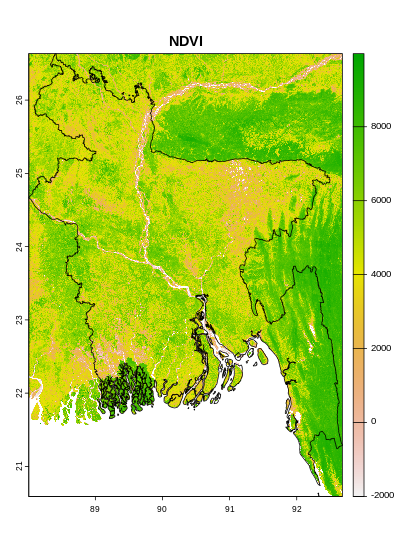

In [24]:
%%R -w 400 -h 550 -u px
plot(ndvi, main="NDVI")
plot(bd$geometry, add=TRUE)

### Clip data `


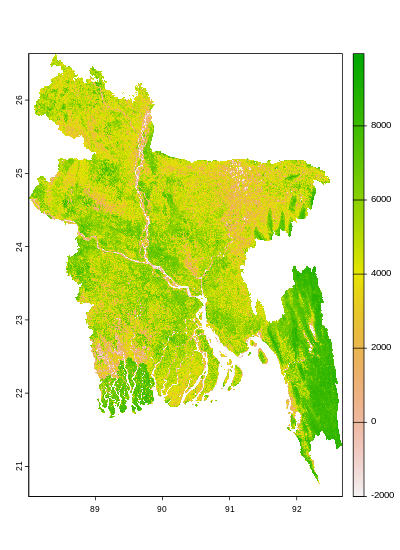

In [25]:
%%R -w 400 -h 550 -u px
ndvi.clip<-crop(ndvi, bd, mask=TRUE)
plot(ndvi.clip)

### Projection

We will use **preject()** function of terra package to reproject the NDVI image to BTM using CRS of DEM raster.

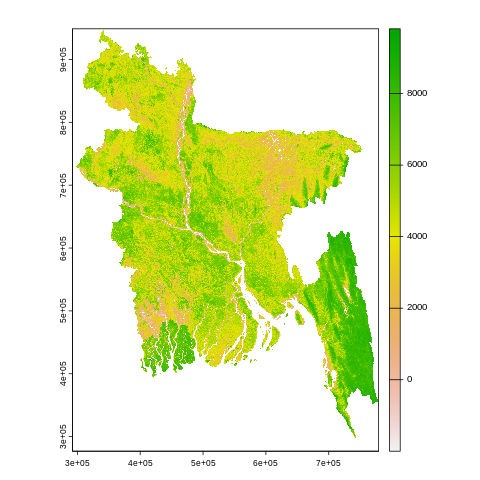

In [28]:
%%R -w 400 -h 550 -u px
dem=rast("/content/drive/MyDrive/Data/Bangladesh/Raster/hilly_dem_BTM.tiff")
ndvi.btm<-terra::project(ndvi.clip, crs(dem))

### Scale 0-1

We expect the NDVI to be between 0  and 1. Due to various reasons, there may values slightly outside this range. First clamp values of the image between 0 and 1.

In [30]:
%%R
ndvi.btm_scale<-ndvi.btm/10000
ndvi.btm_scale<- clamp(ndvi.btm_scale, 0, 1)

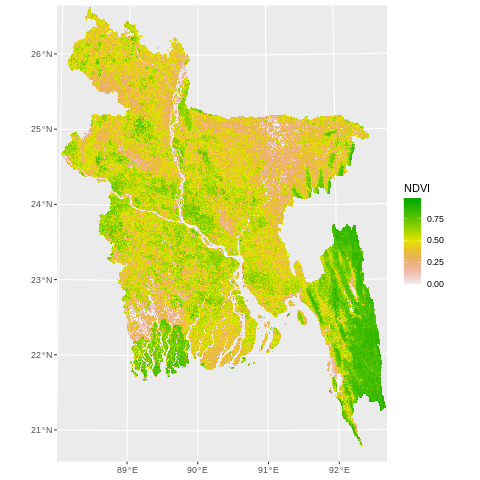

In [43]:
%%R
ggplot() +
  geom_spatraster(data = ndvi.btm_scale) +
   scale_fill_terrain_c() +
  coord_sf(expand = FALSE) +
  labs(fill = "NDVI")

## Batch Processing

### Clipping

Now well perform clipping all NDVI images in NDVI folder. First we will creats a list of images in folder

In [44]:
%%R
ndvi_dir <- "/content/drive/MyDrive/Data/Bangladesh/MODIS/MODIStsp/VI_16Days_250m_v61/NDVI"
ndvi_list <- list.files(ndvi_dir, pattern = "\\.tif$", full.names = TRUE)
ndvi_list

[1] "/content/drive/MyDrive/Data/Bangladesh/MODIS/MODIStsp/VI_16Days_250m_v61/NDVI/MOD13Q1_NDVI_2023_001.tif"
[2] "/content/drive/MyDrive/Data/Bangladesh/MODIS/MODIStsp/VI_16Days_250m_v61/NDVI/MOD13Q1_NDVI_2023_017.tif"
[3] "/content/drive/MyDrive/Data/Bangladesh/MODIS/MODIStsp/VI_16Days_250m_v61/NDVI/MOD13Q1_NDVI_2023_033.tif"
[4] "/content/drive/MyDrive/Data/Bangladesh/MODIS/MODIStsp/VI_16Days_250m_v61/NDVI/MOD13Q1_NDVI_2023_049.tif"


Then we will apply **rast()**  function on this list to create a SpatRaster stack:

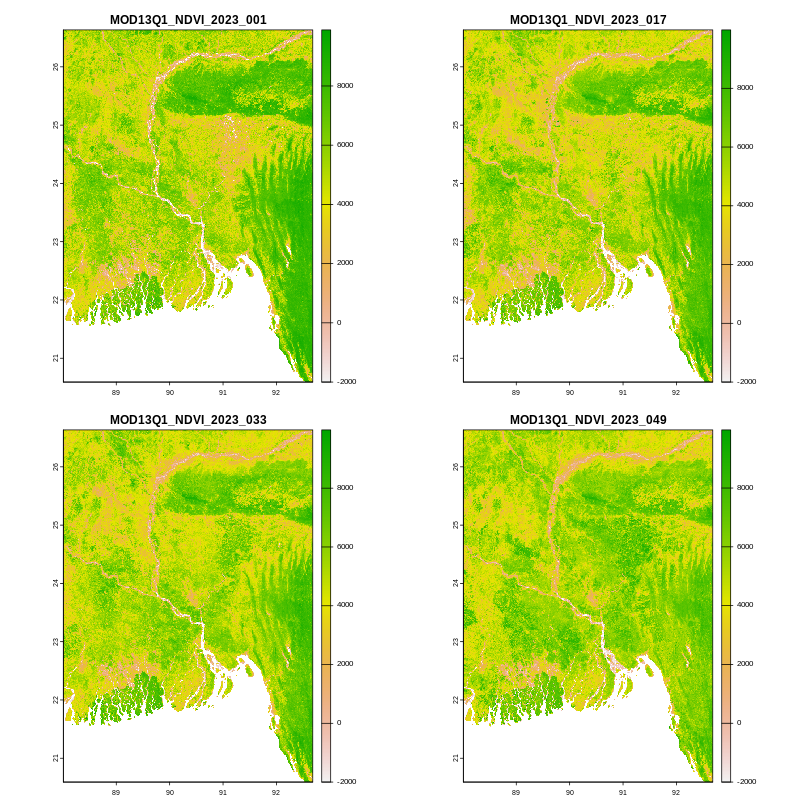

In [45]:
%%R -w 800 -h 800 -u px
s <- rast(ndvi_list)
plot(s)

Finally we will use **crop()** and then **mask()** functions to clip all NDVI raster by  Bangladesh Boundary file:

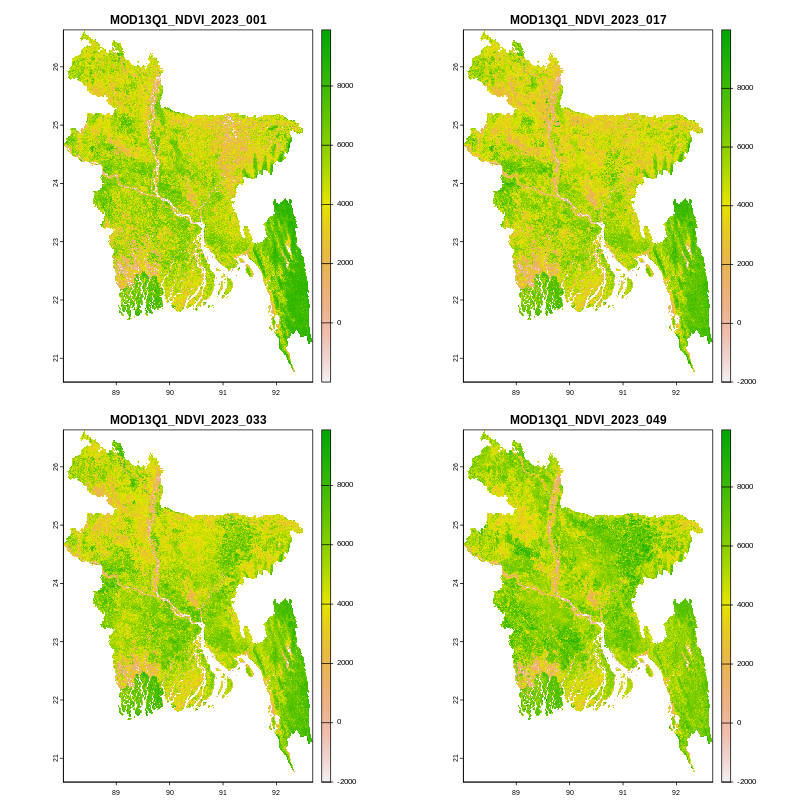

In [46]:
%%R -w 800 -h 800 -u px
s.clip<-crop(s, bd, mask=TRUE)
plot(s.clip)

#### Projection

We can reproject all raster using **project()** function:

In [47]:
%%R
s_btm<-terra::project(s.clip, crs(dem))


#### Rename

We can rename all raster using tidyterra package and  plot them using ggplot2(). The{tidyterra} provids common methods of the tidyverse packages for objects created with the {terra} package: SpatRaster and SpatVector. It also provides geoms for plotting these objects with {ggplot2}.

In [48]:
%%R
s_btm<-s_btm %>%
  rename (Jan_001 = MOD13Q1_NDVI_2023_001,
          Jan_017= MOD13Q1_NDVI_2023_017,
          Feb_033 = MOD13Q1_NDVI_2023_033,
          Feb_049= MOD13Q1_NDVI_2023_049)

#### Convert 0-1 scale

In [49]:
%%R
s_btm_scale = s_btm/10000

We expect the NDVI to be between 0  and 1. Due to various reasons, there may values slightly outside this range. First clamp values of the image between 0 and 1.

In [50]:
%%R
s_btm_scale <- clamp(s_btm_scale, 0, 1)

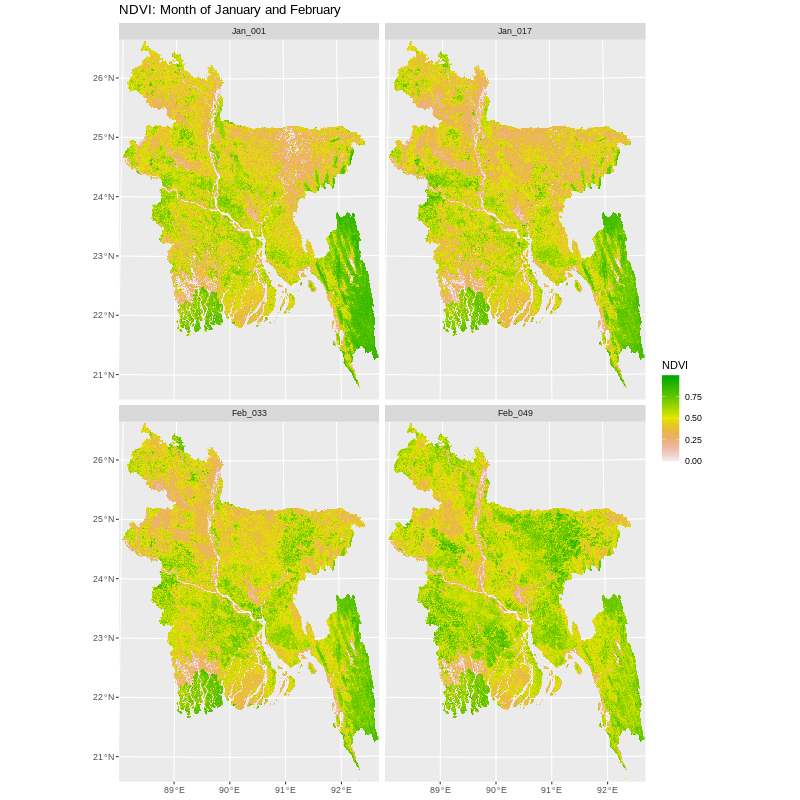

In [51]:
%%R -w 800 -h 800 -u px
ggplot() +
  geom_spatraster(data = s_btm_scale) +
  facet_wrap(~lyr, ncol = 2) +
  scale_fill_terrain_c() +
   coord_sf(expand = FALSE) +
  labs(
    fill = "NDVI",
    title = "NDVI: Month of January and February"
  )